In [29]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [30]:
# Load your data
data = pd.read_csv('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\train_set.csv', header=0)
data.columns = ['Area', 'Year', 'Month', 'Crime_Category', 'Total_Crimes']

# Drop the 'Year' column since it's not used
data.drop('Year', axis=1, inplace=True)

data

,Area,Month,Crime_Category,Total_Crimes
0,15,11,800,98
1,12,10,850,120
2,10,11,850,81
3,3,7,850,134
4,15,8,300,123
...,...,...,...,...
10075,3,1,1700,12
10076,2,1,1900,93
10077,2,6,750,81
10078,17,7,400,24


In [31]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Month', 'Area', 'Crime_Category', 'Total_Crimes']])

# Convert scaled data back to DataFrame for ease of manipulation
scaled_df = pd.DataFrame(scaled_data, columns=['Month', 'Area', 'Crime_Category', 'Total_Crimes'])

scaled_df

,Month,Area,Crime_Category,Total_Crimes
0,0.909091,0.70,0.238095,0.315113
1,0.818182,0.55,0.261905,0.385852
2,0.909091,0.45,0.261905,0.260450
3,0.545455,0.10,0.261905,0.430868
4,0.636364,0.70,0.000000,0.395498
...,...,...,...,...
10075,0.000000,0.10,0.666667,0.038585
10076,0.000000,0.05,0.761905,0.299035
10077,0.454545,0.05,0.214286,0.260450
10078,0.545455,0.80,0.047619,0.077170


In [32]:
scaled_df.sort_values(by=[
'Month'
, 'Crime_Category', 'Area'], inplace=
True
)
scaled_df

,Month,Area,Crime_Category,Total_Crimes
632,0.0,0.00,0.0,0.520900
1486,0.0,0.00,0.0,0.479100
2393,0.0,0.00,0.0,0.681672
7071,0.0,0.00,0.0,0.488746
763,0.0,0.05,0.0,0.389068
...,...,...,...,...
8349,1.0,0.95,1.0,0.077170
3377,1.0,1.00,1.0,0.080386
3398,1.0,1.00,1.0,0.073955
6056,1.0,1.00,1.0,0.070740


In [33]:
# Define the path where you want to save the scaler
directory = r'C:\Users\luigi\Desktop\Third Year\Thesis\Artefact\Data\LSTM'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the full path for the scaler file
scaler_path = os.path.join(directory, 'scaler.gz')

# Save the scaler to the specified path
joblib.dump(scaler, scaler_path)


['C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\LSTM\\scaler.gz']

In [34]:
# Define supervised problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = data
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


reframed = series_to_supervised(scaled_df, 1, 1)
reframed

,Month(t-1),Area(t-1),Crime_Category(t-1),Total_Crimes(t-1),Month(t),Area(t),Crime_Category(t),Total_Crimes(t)
1486,0.0,0.00,0.0,0.520900,0.0,0.00,0.0,0.479100
2393,0.0,0.00,0.0,0.479100,0.0,0.00,0.0,0.681672
7071,0.0,0.00,0.0,0.681672,0.0,0.00,0.0,0.488746
763,0.0,0.00,0.0,0.488746,0.0,0.05,0.0,0.389068
2031,0.0,0.05,0.0,0.389068,0.0,0.05,0.0,0.401929
...,...,...,...,...,...,...,...,...
8349,1.0,0.95,1.0,0.061093,1.0,0.95,1.0,0.077170
3377,1.0,0.95,1.0,0.077170,1.0,1.00,1.0,0.080386
3398,1.0,1.00,1.0,0.080386,1.0,1.00,1.0,0.073955
6056,1.0,1.00,1.0,0.073955,1.0,1.00,1.0,0.070740


In [35]:
# Assume 'reframed' is your final DataFrame after preprocessing and reshaping
n_features = 4  # This should be set to the number of features you're actually using
n_timesteps = 1  # This is the number of lag timesteps you used in your series_to_supervised function

values = reframed.values
X, y = values[:, :-n_features], values[:, -1]  # Adjust depending on your output configuration
X = X.reshape((X.shape[0], n_timesteps, n_features))


In [36]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dense(1))  # Assuming a single output node for regression
model.compile(loss='mae', optimizer='adam')

In [37]:
# Fit model
model.fit(X, y, epochs=100, batch_size=72, verbose=2)

# Assume 'model' is your trained LSTM model
model.save('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\LSTM\\lstm_model.h5')

Epoch 1/100
140/140 - 2s - loss: 0.1133 - 2s/epoch - 17ms/step
Epoch 2/100
140/140 - 1s - loss: 0.0589 - 663ms/epoch - 5ms/step
Epoch 3/100
140/140 - 1s - loss: 0.0575 - 614ms/epoch - 4ms/step
Epoch 4/100
140/140 - 1s - loss: 0.0577 - 604ms/epoch - 4ms/step
Epoch 5/100
140/140 - 1s - loss: 0.0575 - 692ms/epoch - 5ms/step
Epoch 6/100
140/140 - 1s - loss: 0.0572 - 634ms/epoch - 5ms/step
Epoch 7/100
140/140 - 1s - loss: 0.0574 - 611ms/epoch - 4ms/step
Epoch 8/100
140/140 - 1s - loss: 0.0574 - 693ms/epoch - 5ms/step
Epoch 9/100
140/140 - 1s - loss: 0.0572 - 616ms/epoch - 4ms/step
Epoch 10/100
140/140 - 1s - loss: 0.0572 - 618ms/epoch - 4ms/step
Epoch 11/100
140/140 - 1s - loss: 0.0571 - 632ms/epoch - 5ms/step
Epoch 12/100
140/140 - 1s - loss: 0.0571 - 694ms/epoch - 5ms/step
Epoch 13/100
140/140 - 1s - loss: 0.0570 - 612ms/epoch - 4ms/step
Epoch 14/100
140/140 - 1s - loss: 0.0570 - 530ms/epoch - 4ms/step
Epoch 15/100
140/140 - 1s - loss: 0.0571 - 592ms/epoch - 4ms/step
Epoch 16/100
140/140 

In [38]:
# Load the test set
test_data = pd.read_csv('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\test_set.csv', header=0)
test_data.columns = ['Area', 'Year', 'Month', 'Crime_Category', 'Total_Crimes']

# Convert test data to numeric, handling errors
test_data = test_data.apply(pd.to_numeric, errors='coerce')
test_data.dropna(inplace=True)  # Drop rows with NaN values after conversion

# Drop the 'Year' column as it's not used
test_data.drop('Year', axis=1, inplace=True)

In [39]:
# Load the saved scaler
scaler = joblib.load('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\LSTM\\scaler.gz')

In [40]:
test_scaled = scaler.transform(test_data[['Month', 'Area', 'Crime_Category', 'Total_Crimes']])

# Reshape test data for LSTM [samples, timesteps, features]
test_X = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[1]))

# Load the trained LSTM model
model = load_model('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\LSTM\\lstm_model.h5')

# Predict using the LSTM model
test_predictions = model.predict(test_X)

# Inverse transform the predictions to get them back to the original scale
# The scaler's inverse_transform method expects the same number of features as it was fit with
# Create a full array with dummy data to match the shape expected by the scaler
dummy_features = np.zeros((test_predictions.shape[0], test_scaled.shape[1] - 1))
full_test_predictions = np.concatenate([dummy_features, test_predictions], axis=1)
final_predictions = scaler.inverse_transform(full_test_predictions)[:, -1]

# Add predictions to the test dataframe for comparison
test_data['Predicted_Crimes'] = final_predictions

# Print the test data with predictions
print(test_data[['Total_Crimes', 'Predicted_Crimes']])

79/79 [==============================] - 1s 4ms/step
      Total_Crimes  Predicted_Crimes
0               11         14.255557
1               90         86.045939
2               28         28.335163
3              216        196.645695
4               73         73.959953
...            ...               ...
2515            26         28.202996
2516           141        137.339712
2517           212        198.118204
2518            66         67.413735
2519            50         51.868532

[2520 rows x 2 columns]


In [41]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['Total_Crimes'], test_data['Predicted_Crimes'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 38.31243935779811
Root Mean Squared Error (RMSE): 6.189704302937105


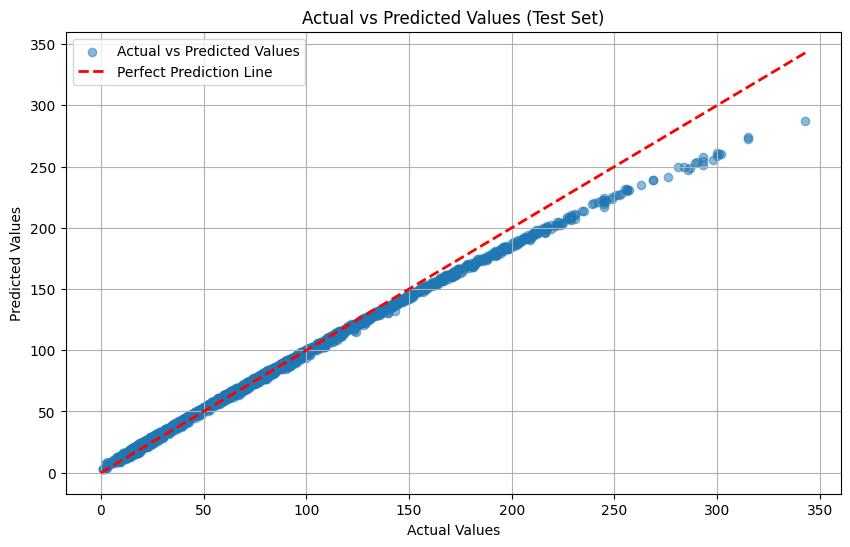

In [42]:
# Plotting the actual vs predicted crimes
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Total_Crimes'], test_data['Predicted_Crimes'], alpha=0.5, label='Actual vs Predicted Values')

# Generate a diagonal line (y=x) for perfect predictions
max_val = max(test_data['Total_Crimes'].max(), test_data['Predicted_Crimes'].max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction Line')

plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()